In [1]:
import pandas as pd
import numpy as np
import loompy as lp
from collections import Counter
from scipy import stats
import time
import matplotlib.pyplot as plt

In [2]:
#a e s t h e t i c s
vermeer_hex = ("#A65141", "#E7CDC2", "#80A0C7", "#394165", "#FCF9F0", "#B1934A",
             "#DCA258", "#100F14", "#8B9DAF", "#EEDA9D")
vermeer = [(tuple(int(h.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))) for h in vermeer_hex]
vermeer.pop(4)

#milkmaid - vermeer
milkmaid_hex = ("#48211A","#376597","#537270","#556246","#928F6B","#CCAF69",
               "#ECE5D3","#104A8A","#C5AC8E","#889F95","#7C4728","#00295D",
               "#D9B196")
milkmaid = [(tuple(int(h.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))) for h in milkmaid_hex]
milkmaid.pop(6)

#view of delft - vermeer
delft_hex = ("#78A8D1","#D5BF98","#E3C78F","#FDF9F8","#867D6C","#A04437","#AF7366",
         "#EFBF6A","#8E7C56","#CDD4E4","#8B6C4F","#B4B7B9")
delft = [(tuple(int(h.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))) for h in delft_hex]

from cycler import cycler
art_cycle = cycler(color=milkmaid)

def aesth(violin):
    for pc in violin['bodies']:
        pc.set_alpha(0.9)
    violin['cquantiles'].set_color('k')

In [3]:
desai_files = ['dmso','idu']
tenx_files = ['pbmc_1k_v3','pbmc_10k_v3','heart_1k_v3','heart_10k_v3','neuron_1k_v3','neuron_10k_v3',\
             'brain_5k_v3','brain_nuc_5k_v3']
kb_files = ['/home/ggorin/count_data/loom_desai_kb/desai_'+j+'.loom' for j in desai_files] + \
           ['/home/ggorin/count_data/loom_10x_kb/'+j+'.loom' for j in tenx_files]
vc_files = ['/home/ggorin/count_data/loom_desai_vc/desai_'+j+'_cr.loom' for j in desai_files] + \
           ['/home/ggorin/count_data/loom_10x_vc/'+j+'_cr.loom' for j in tenx_files]
sm_files = ['/home/ggorin/count_data/loom_salmon/desai_'+j+'_v2.loom' for j in desai_files] + \
           ['/home/ggorin/count_data/loom_salmon/'+j+'.loom' for j in tenx_files] #sm is short for SalMon

In [4]:
nfiles = len(kb_files)

In [5]:
!mkdir -p gg_220208_fig

In [6]:
figdir = 'gg_220208_fig'

In [7]:
kb_files

['/home/ggorin/count_data/loom_desai_kb/desai_dmso.loom',
 '/home/ggorin/count_data/loom_desai_kb/desai_idu.loom',
 '/home/ggorin/count_data/loom_10x_kb/pbmc_1k_v3.loom',
 '/home/ggorin/count_data/loom_10x_kb/pbmc_10k_v3.loom',
 '/home/ggorin/count_data/loom_10x_kb/heart_1k_v3.loom',
 '/home/ggorin/count_data/loom_10x_kb/heart_10k_v3.loom',
 '/home/ggorin/count_data/loom_10x_kb/neuron_1k_v3.loom',
 '/home/ggorin/count_data/loom_10x_kb/neuron_10k_v3.loom',
 '/home/ggorin/count_data/loom_10x_kb/brain_5k_v3.loom',
 '/home/ggorin/count_data/loom_10x_kb/brain_nuc_5k_v3.loom']

In [8]:
vc_files

['/home/ggorin/count_data/loom_desai_vc/desai_dmso_cr.loom',
 '/home/ggorin/count_data/loom_desai_vc/desai_idu_cr.loom',
 '/home/ggorin/count_data/loom_10x_vc/pbmc_1k_v3_cr.loom',
 '/home/ggorin/count_data/loom_10x_vc/pbmc_10k_v3_cr.loom',
 '/home/ggorin/count_data/loom_10x_vc/heart_1k_v3_cr.loom',
 '/home/ggorin/count_data/loom_10x_vc/heart_10k_v3_cr.loom',
 '/home/ggorin/count_data/loom_10x_vc/neuron_1k_v3_cr.loom',
 '/home/ggorin/count_data/loom_10x_vc/neuron_10k_v3_cr.loom',
 '/home/ggorin/count_data/loom_10x_vc/brain_5k_v3_cr.loom',
 '/home/ggorin/count_data/loom_10x_vc/brain_nuc_5k_v3_cr.loom']

In [9]:
sm_files

['/home/ggorin/count_data/loom_salmon/desai_dmso_v2.loom',
 '/home/ggorin/count_data/loom_salmon/desai_idu_v2.loom',
 '/home/ggorin/count_data/loom_salmon/pbmc_1k_v3.loom',
 '/home/ggorin/count_data/loom_salmon/pbmc_10k_v3.loom',
 '/home/ggorin/count_data/loom_salmon/heart_1k_v3.loom',
 '/home/ggorin/count_data/loom_salmon/heart_10k_v3.loom',
 '/home/ggorin/count_data/loom_salmon/neuron_1k_v3.loom',
 '/home/ggorin/count_data/loom_salmon/neuron_10k_v3.loom',
 '/home/ggorin/count_data/loom_salmon/brain_5k_v3.loom',
 '/home/ggorin/count_data/loom_salmon/brain_nuc_5k_v3.loom']

Set up the parameters. `norm` defines whether cell size-normalized counts should be used. `filt_genes` discards low-expressed genes. `cf` defines the correlation measure.

In [10]:
norm = False
filt_genes = True
cf = 'spearman'

In [ ]:
kb_attrs = ['gene_name','barcode']
vc_attrs = ['Gene','CellID']
r_attr = [kb_attrs[0],vc_attrs[0]]
c_attr = [kb_attrs[1],vc_attrs[1]]

Fix `velocyto` naming.

In [12]:
# for j in range(nfiles):
#     with lp.connect(vc_files[j]) as ds: #fix vcy naming
#         ds.ca['barcode'] = np.asarray([x.split(':')[1][:-1] for x in ds.ca[c_attr[1]]],dtype=ds.ca[c_attr[1]].dtype)
#         ds.ra['gene_name'] = ds.ra[r_attr[1]]

In [13]:
def process_pair(datasets1,datasets2,softnames,cf,norm,filt_genes):
    t1 = time.time()
    OUT = []
    nfiles = len(datasets1)
    for j in range(nfiles):
        print('-----------------')
        filenames = datasets1[j],datasets2[j]
        genes = []
        bcs = []
        for i in range(len(filenames)):
            filename = filenames[i]
            with lp.connect(filename) as ds:
                genes.append(ds.ra['gene_name']) #assuming we've already harmonized vcy names
                bcs.append(ds.ca['barcode'])
        for i in range(len(filenames)):
            filename = filenames[i]
            print(filename)
#             print('{:} barcodes detected.'.format(len(bcs[i])))
            bcs[i] = [k for k, v in Counter(bcs[i]).items() if v == 1]
#             print('{:} unique barcodes.'.format(len(set(bcs[i]))))
#             print('{:} genes detected.'.format(len(genes[i])))
            genes[i] = [k for k, v in Counter(genes[i]).items() if v == 1]
#             print('{:} genes after removing duplicates.'.format(len(genes[i])))
        bcs = [set(x) for x in bcs]
        genes = [set(x) for x in genes]

#         softnames = ['kb','vcy']
        bc_ov = len(bcs[1].intersection(bcs[0]))
        bc_tot = len(bcs[1].union(bcs[0]))
#         print('{:} barcodes only in {}.'.format(len(bcs[0].difference(bcs[1])),softnames[0]))
#         print('{:} barcodes only in {}.'.format(len(bcs[1].difference(bcs[0])),softnames[1]))
#         print('{:} barcodes overlap.'.format(bc_tot))
        print('{:.2f}% barcode Jaccard index.'.format(bc_ov/bc_tot*100))
        bcs_ = list(bcs[1].intersection(bcs[0]))

#         print('{:} genes only in {}.'.format(len(genes[0].difference(genes[1])),softnames[0]))
#         print('{:} genes only in {}.'.format(len(genes[1].difference(genes[0])),softnames[1]))
#         print('{:} genes overlap.'.format(len(genes[1].intersection(genes[0]))))
        genes_ = list(genes[1].intersection(genes[0]))

        S = []
        U = []
        for i in range(len(filenames)):
            filename = filenames[i]
#             print(filename)
            with lp.connect(filename) as ds:
                gene_ind = [np.where(ds.ra['gene_name']==x)[0][0] for x in genes_]
                cell_ind = [np.where(ds.ca['barcode']==x)[0][0] for x in bcs_]
                S.append(ds.layers['spliced'][:][gene_ind][:,cell_ind])
                U.append(ds.layers['unspliced'][:][gene_ind][:,cell_ind])

        ngen = len(genes_)
        ncell = len(bcs_)

        print('Computing correlations over genes.')
        corr_over_genes_S = get_corr(S,kind='genes',cf=cf,norm=norm,filt_genes=filt_genes)
        corr_over_genes_U = get_corr(U,kind='genes',cf=cf,norm=norm,filt_genes=filt_genes)
        print('Computing correlations over cells.')
        corr_over_cells_S = get_corr(S,kind='cells',cf=cf,norm=norm,filt_genes=filt_genes)
        corr_over_cells_U = get_corr(U,kind='cells',cf=cf,norm=norm,filt_genes=filt_genes)

        OUT.append([corr_over_genes_S,corr_over_genes_U,corr_over_cells_S,corr_over_cells_U])
    t2 = time.time()
    print('Processing time: {:.1f} seconds.'.format(t2-t1))
    return OUT

In [14]:
def get_corr(X,kind='cells',cf='pearson',norm=False,filt_genes=False):
    if cf=='pearson':
        corrfun = stats.pearsonr
    elif cf=='spearman':
        corrfun = stats.spearmanr
    ngen = X[0].shape[0]
    ncell = X[0].shape[1]
    
    Y = np.asarray(X)
    if filt_genes:
        filt = np.logical_and(((X[0]>0).sum(1))>3 , ((X[1]>0).sum(1))>3) #genes observed in more than three cells
        Y = Y[:,filt,:]
        print('Fraction genes discarded due to low expression: {:.2f}%.'.format(np.mean(~filt)*100))
        ngen = np.sum(filt)
    
    if norm:
        Y = [x/x.sum(0) for x in Y]
    
    if kind == 'genes':
        corr_ = np.zeros(ncell)
        for i in range(ncell):
            c_ = corrfun(Y[0,:,i],Y[1,:,i])[0]
            if np.isnan(c_):
                corr_[i] = 2
            else:
                corr_[i] = c_
    if kind == 'cells':
        corr_ = np.zeros(ngen)
        for i in range(ngen):
            c_ = corrfun(Y[0,i,:],Y[1,i,:])[0]
            if np.isnan(c_):
                corr_[i] = 2
            else:
                corr_[i] = c_
    
    if sum(corr_>1) > 0:
        print('Invalid {} correlations: {:} out of {:} ({:.2f}%).'.format(
            cf,sum(corr_>1),len(corr_),100*sum(corr_>1)/len(corr_)))
    corr_ = corr_[corr_<=1]
    return corr_

In [15]:
def viz_violin(OUT,softnames,nfiles):
    fig1,ax1 = plt.subplots(2,2,figsize=(20,5))
    showextrema=False

    for ax in ax1.flatten():
        ax.set_prop_cycle(art_cycle)

    fs = 20
    qdef = [.25,.5,.75]
    for j in range(nfiles):
        v1 = ax1[0,0].violinplot([OUT[j][0]],[j],quantiles=[[.25,.5,.75]],showextrema=showextrema)
        v2 = ax1[0,1].violinplot([OUT[j][1]],[j],quantiles=[[.25,.5,.75]],showextrema=showextrema)
        v3 = ax1[1,0].violinplot([OUT[j][2]],[j],quantiles=[[.25,.5,.75]],showextrema=showextrema)
        v4 = ax1[1,1].violinplot([OUT[j][3]],[j],quantiles=[[.25,.5,.75]],showextrema=showextrema)

        q = np.quantile(OUT[j][0],qdef)

        aesth(v1)
        aesth(v2)
        aesth(v3)
        aesth(v4)

    for ax in ax1.flatten():
        ax.tick_params(bottom=False,labelbottom=False)
    #     ax.get_xaxis().set_visible(False)

        ax.set_ylim([-0.25,1])
        ax.grid(axis='y',which='major')
    ax1[0,1].tick_params(labelleft=False)
    ax1[1,1].tick_params(labelleft=False)
    ax1[0,0].set_ylabel(r'$\rho$ by gene',fontsize=fs)
    ax1[1,0].set_ylabel(r'$\rho$ by cell',fontsize=fs)
    ax1[1,1].set_xlabel('Unspliced',fontsize=fs)
    ax1[1,0].set_xlabel('Spliced',fontsize=fs)

    fig1.tight_layout()
    fig1.savefig('./'+figdir+'/'+softnames[0]+'_'+softnames[1]+'.png',dpi=600)

    # plt.violinplot(,0)

-----------------
/home/ggorin/count_data/loom_desai_kb/desai_dmso.loom
/home/ggorin/count_data/loom_salmon/desai_dmso_v2.loom
89.97% barcode Jaccard index.
Computing correlations over genes.
Fraction genes discarded due to low expression: 56.27%.
Fraction genes discarded due to low expression: 54.04%.
Computing correlations over cells.
Fraction genes discarded due to low expression: 56.27%.
Fraction genes discarded due to low expression: 54.04%.
-----------------
/home/ggorin/count_data/loom_desai_kb/desai_idu.loom
/home/ggorin/count_data/loom_salmon/desai_idu_v2.loom
91.96% barcode Jaccard index.
Computing correlations over genes.
Fraction genes discarded due to low expression: 51.86%.
Fraction genes discarded due to low expression: 51.00%.
Computing correlations over cells.
Fraction genes discarded due to low expression: 51.86%.
Fraction genes discarded due to low expression: 51.00%.
-----------------
/home/ggorin/count_data/loom_10x_kb/pbmc_1k_v3.loom
/home/ggorin/count_data/loom_s

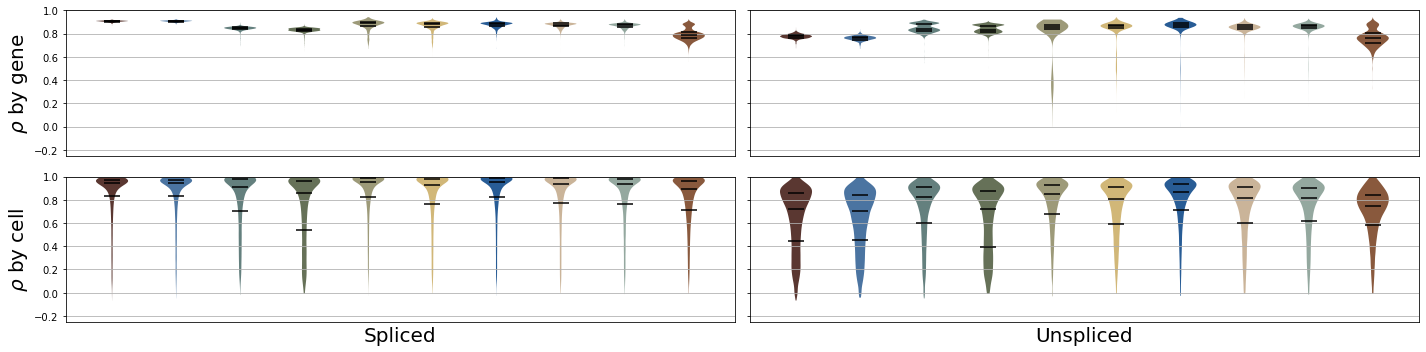

In [16]:
softnames = ['kb','sm']
nfil = len(kb_files)
datasets1 = kb_files[:nfil]
datasets2 = sm_files[:nfil]
OUT = process_pair(datasets1,datasets2,softnames,cf,norm,filt_genes)
viz_violin(OUT,softnames,nfil)

-----------------
/home/ggorin/count_data/loom_desai_kb/desai_dmso.loom
/home/ggorin/count_data/loom_desai_vc/desai_dmso_cr.loom
95.07% barcode Jaccard index.
Computing correlations over genes.
Fraction genes discarded due to low expression: 57.27%.
Fraction genes discarded due to low expression: 58.45%.
Computing correlations over cells.
Fraction genes discarded due to low expression: 57.27%.
Fraction genes discarded due to low expression: 58.45%.
-----------------
/home/ggorin/count_data/loom_desai_kb/desai_idu.loom
/home/ggorin/count_data/loom_desai_vc/desai_idu_cr.loom
97.28% barcode Jaccard index.
Computing correlations over genes.
Fraction genes discarded due to low expression: 53.13%.
Fraction genes discarded due to low expression: 54.53%.
Computing correlations over cells.
Fraction genes discarded due to low expression: 53.13%.
Fraction genes discarded due to low expression: 54.53%.
-----------------
/home/ggorin/count_data/loom_10x_kb/pbmc_1k_v3.loom
/home/ggorin/count_data/lo

/home/ggorin/miniconda3/lib/python3.9/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


Invalid spearman correlations: 1 out of 1261 (0.08%).
Computing correlations over cells.
Fraction genes discarded due to low expression: 56.51%.
Fraction genes discarded due to low expression: 58.66%.
-----------------
/home/ggorin/count_data/loom_10x_kb/neuron_10k_v3.loom
/home/ggorin/count_data/loom_10x_vc/neuron_10k_v3_cr.loom
94.99% barcode Jaccard index.
Computing correlations over genes.
Fraction genes discarded due to low expression: 47.90%.
Fraction genes discarded due to low expression: 47.69%.
Computing correlations over cells.
Fraction genes discarded due to low expression: 47.90%.
Fraction genes discarded due to low expression: 47.69%.
-----------------
/home/ggorin/count_data/loom_10x_kb/brain_5k_v3.loom
/home/ggorin/count_data/loom_10x_vc/brain_5k_v3_cr.loom
95.47% barcode Jaccard index.
Computing correlations over genes.
Fraction genes discarded due to low expression: 51.36%.
Fraction genes discarded due to low expression: 50.49%.
Computing correlations over cells.
Fract

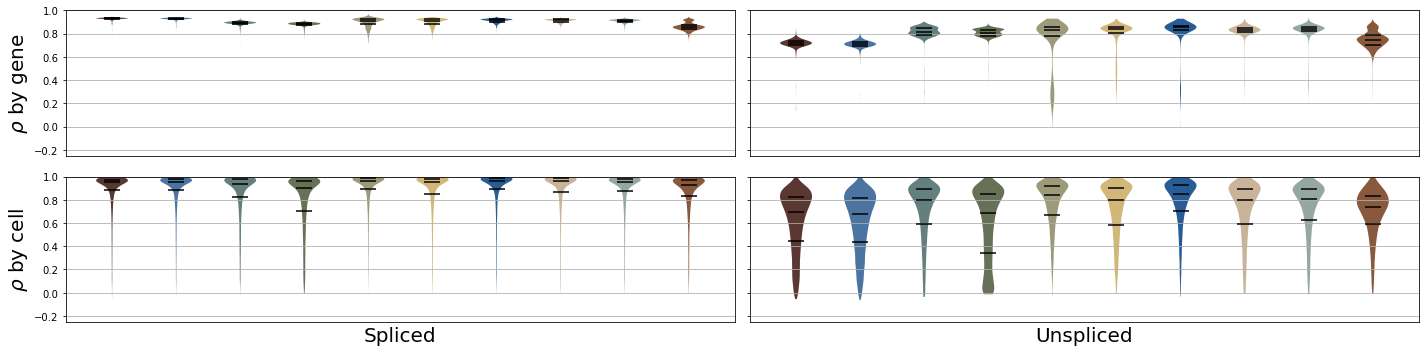

In [17]:
softnames = ['kb','vcy']
nfil = len(kb_files)
datasets1 = kb_files[:nfil]
datasets2 = vc_files[:nfil]
OUT = process_pair(datasets1,datasets2,softnames,cf,norm,filt_genes)
viz_violin(OUT,softnames,nfil)

-----------------
/home/ggorin/count_data/loom_salmon/desai_dmso_v2.loom
/home/ggorin/count_data/loom_desai_vc/desai_dmso_cr.loom
92.73% barcode Jaccard index.
Computing correlations over genes.
Fraction genes discarded due to low expression: 55.80%.
Fraction genes discarded due to low expression: 57.21%.
Computing correlations over cells.
Fraction genes discarded due to low expression: 55.80%.
Fraction genes discarded due to low expression: 57.21%.
-----------------
/home/ggorin/count_data/loom_salmon/desai_idu_v2.loom
/home/ggorin/count_data/loom_desai_vc/desai_idu_cr.loom
93.34% barcode Jaccard index.
Computing correlations over genes.
Fraction genes discarded due to low expression: 51.40%.
Fraction genes discarded due to low expression: 53.19%.
Computing correlations over cells.
Fraction genes discarded due to low expression: 51.40%.
Fraction genes discarded due to low expression: 53.19%.
-----------------
/home/ggorin/count_data/loom_salmon/pbmc_1k_v3.loom
/home/ggorin/count_data/

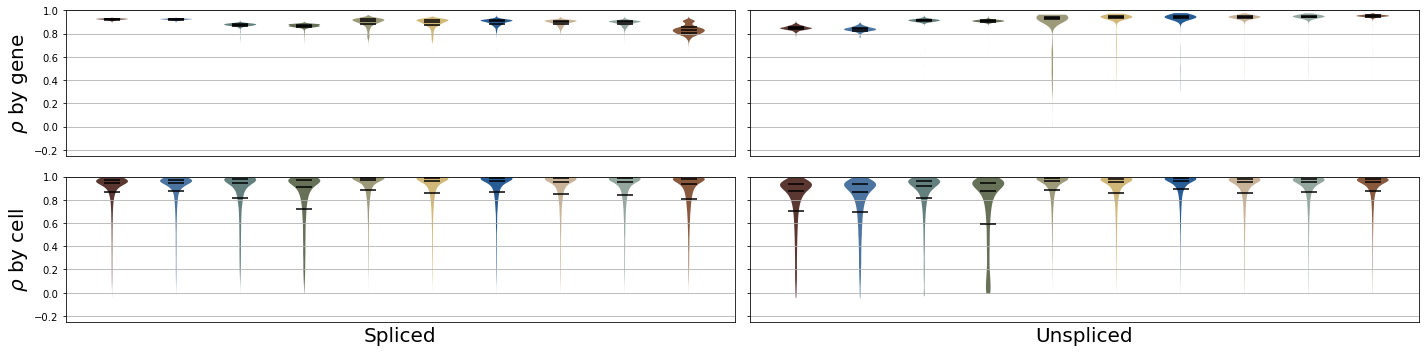

In [22]:
softnames = ['sm','vcy']
nfil = len(sm_files)
datasets1 = sm_files[:nfil]
datasets2 = vc_files[:nfil]
OUT = process_pair(datasets1,datasets2,softnames,cf,norm,filt_genes)
viz_violin(OUT,softnames,nfil)